In [22]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [23]:
import os
import shutil

# Define the dataset directories
data_dir = 'main_data'  # Replace with your dataset directory
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Define the new directory
combined_dir = os.path.join(data_dir, 'combined_dataset')

# Subfolders
subfolders = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']

# Function to copy images
def copy_images(source_dir, target_dir, subfolder):
    source_folder = os.path.join(source_dir, subfolder)
    target_folder = os.path.join(target_dir, subfolder)
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    for file_name in os.listdir(source_folder):
        source_file = os.path.join(source_folder, file_name)
        target_file = os.path.join(target_folder, file_name)
        shutil.copy(source_file, target_file)

# Copy images from both test and train to the new directory
for folder in subfolders:
    copy_images(train_dir, combined_dir, folder)
    copy_images(test_dir, combined_dir, folder)


In [24]:
# load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images, [label] * len(images)

In [25]:
data_dir = 'main_data/combined_dataset'
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

all_images = []
all_labels = []
for folder in folders:
    images, label_list = load_images_from_folder(os.path.join(data_dir, folder), labels[folder])
    all_images.extend(images)
    all_labels.extend(label_list)

# Convert to numpy arrays
all_images = np.array(all_images).reshape(-1, 128, 128, 1) / 255.0
all_labels = to_categorical(all_labels, num_classes=4)

# Data Augmentation
data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  # small horizontal shifts
    height_shift_range=0.05, # small vertical shifts
    zoom_range=0.05,         # slight zoom
    horizontal_flip=True,    # horizontal flip
    fill_mode='nearest'
)

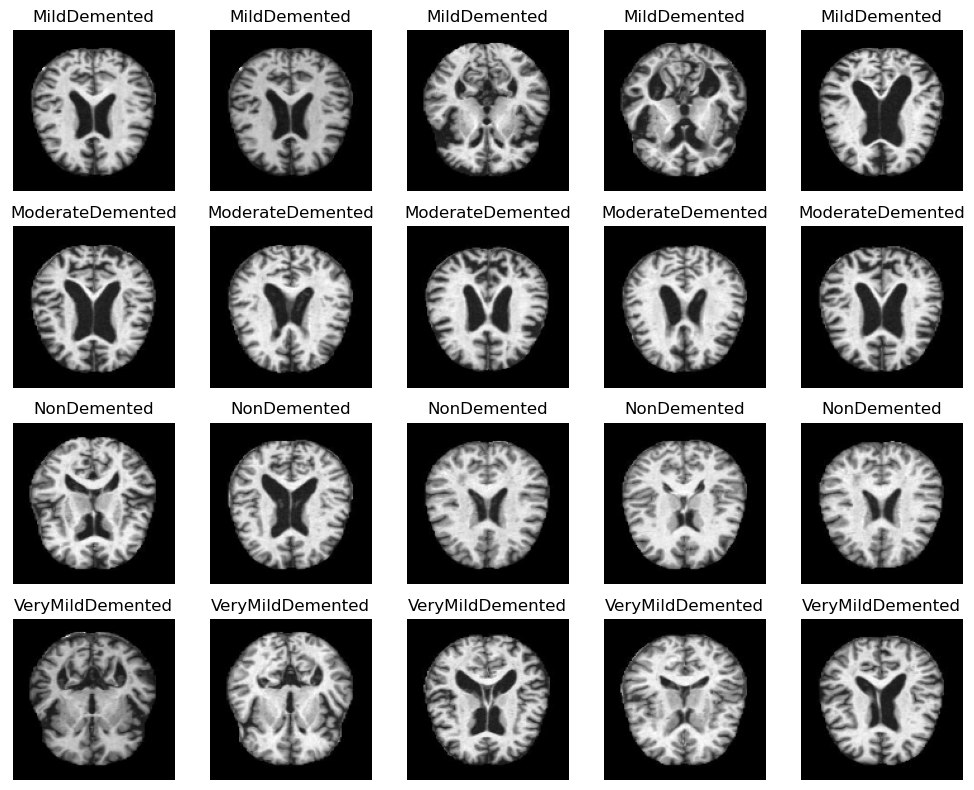

In [26]:
# display images
def display_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_images, figsize=(10, 2 * len(class_names)))
    for i, class_name in enumerate(class_names):
        class_images = [img for img, label in zip(images, labels) if np.argmax(label) == i]
        for j in range(num_images):
            if j < len(class_images):
                ax = axes[i, j]
                ax.imshow(class_images[j].squeeze(), cmap='gray')
                ax.set_title(class_name)
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
display_images(all_images, all_labels, class_names, num_images=5)


In [27]:
import os

# Define the path to the combined dataset directory
combined_dataset_dir = 'main_data/combined_dataset'  # Replace with the actual path to your combined dataset

# List of subfolders
subfolders = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Iterate through each subfolder and count the images
for subfolder in subfolders:
    subfolder_path = os.path.join(combined_dataset_dir, subfolder)
    image_count = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
    image_counts[subfolder] = image_count

# Print the counts
for subfolder, count in image_counts.items():
    print(f"{subfolder}: {count} images")

# Total images
total_images = sum(image_counts.values())
print(f"Total images in combined dataset: {total_images}")


MildDemented: 896 images
VeryMildDemented: 2240 images
ModerateDemented: 64 images
NonDemented: 3200 images
Total images in combined dataset: 6400


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Given data_augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Load your images into a dictionary structure
# images_dict structure: {'class_label': [list_of_image_arrays]}
images_dict = {
    'MildDemented': [],  # Replace with your loaded images
    'VeryMildDemented': [],
    'ModerateDemented': [],
    'NonDemented': []
}

# Define your target number of images per class, for example, the mean size of classes
target_number = np.mean([len(images) for images in images_dict.values()]).astype(int)

# Oversample the minority classes using data augmentation
for class_label, image_list in images_dict.items():
    current_number = len(image_list)
    if current_number < target_number:
        new_images_needed = target_number - current_number
        new_images = []
        while len(new_images) < new_images_needed:
            for image in image_list:
                image = image.reshape((1,) + image.shape)  # Reshape image for data_augmentation
                for x, val in data_augmentation.flow(image, batch_size=1):
                    new_images.append(x[0])
                    if len(new_images) == new_images_needed:
                        break
                if len(new_images) == new_images_needed:
                    break
        images_dict[class_label].extend(new_images)


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils import resample
import cv2
import numpy as np
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

def load_images(image_directory):
    images = []
    for img_path in Path(image_directory).glob('*.jpg'):  # Adjust the pattern if your images have a different format
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)  # or cv2.IMREAD_COLOR for color images
        if img is not None:
            images.append(img)
    return images
# Load your actual image data into these lists
images = {
    'MildDemented': load_images('main_data/combined_dataset/MildDemented'),  # Replace with your image-loading function
    'VeryMildDemented': load_images('main_data/combined_dataset/VeryMildDemented'),
    'ModerateDemented': load_images('main_data/combined_dataset/ModerateDemented'),
    'NonDemented': load_images('main_data/combined_dataset/NonDemented')
}

# Define the target number of images per class
# Make sure that the target size is at least 1
target_size = max(1, sum(len(images[class_name]) for class_name in images) // len(images))

# Initialize the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Oversample the minority classes using data augmentation
for class_name in ['MildDemented', 'ModerateDemented']:
    width_shift_range=0.05,  # small horizontal shifts
    height_shift_range=0.05, # small vertical shifts
    zoom_range=0.05,         # slight zoom
    horizontal_flip=True,    # horizontal flip
    fill_mode='nearest'

# Undersample the majority classes
for class_name in ['VeryMildDemented', 'NonDemented']:
    if len(images[class_name]) > target_size:
        images[class_name] = resample(images[class_name], replace=False, n_samples=target_size, random_state=42)

# Check the balancing
for class_name, image_list in images.items():
    print(f"{class_name} has {len(image_list)} images.")


MildDemented has 896 images.
VeryMildDemented has 1600 images.
ModerateDemented has 64 images.
NonDemented has 1600 images.


In [30]:
import cv2
import numpy as np
from skimage import exposure

def preprocess_images(folder):
    images = []
    labels = []
    subfolders = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']
    label_map = {'MildDemented': 0, 'VeryMildDemented': 1, 'ModerateDemented': 2, 'NonDemented': 3}
    desired_size = (128, 128)  # Updated resolution
    binarization_threshold = 128  # Empirical threshold, adjust as needed

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Resize the image
                img = cv2.resize(img, desired_size, interpolation=cv2.INTER_CUBIC)

                # Contrast enhancement
                img = exposure.equalize_adapthist(img)
                
                # Binarization
                _, img = cv2.threshold(img, binarization_threshold, 255, cv2.THRESH_BINARY)
                #img = img / 255.0  # Normalize pixel values

                images.append(img.flatten())
                labels.append(label_map[subfolder])

    return np.array(images), np.array(labels)

# Usage
X, y = preprocess_images('main_data/combined_dataset')


In [31]:
print(X.shape, X.dtype)
print(y.shape, y.dtype)


(6400, 16384) float64
(6400,) int64


In [32]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: {conf_matrix}")


Accuracy: 0.4921875
Confusion Matrix: [[  0   0   0 283]
 [  0   0   0 666]
 [  0   0   0  26]
 [  0   0   0 945]]


/Users/arushisethi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushisethi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arushisethi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


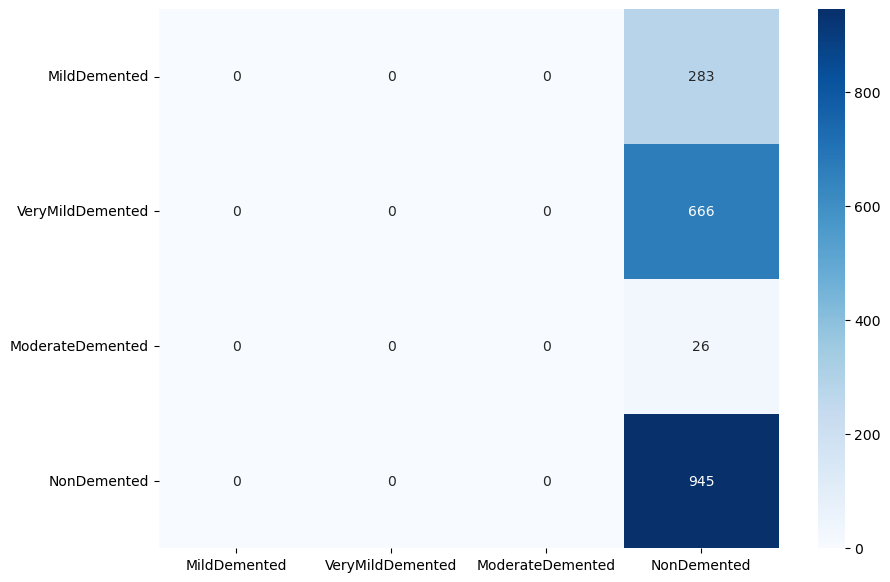

In [33]:
# Define class names as per your dataset
class_names = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# Display the confusion matrix
plt.show()